In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from scipy.stats import norm, qmc

In [2]:
class MCoptionPricer:
    # allowed stuff
    types = {'put', 'call'}
    styles = {'european', 'daibarrier'}
    methods = {'euler', 'milstein'}
    varReductionMethods = {'none', 'antithetic', 'importance', 'control'}
    
    def __init__(self, optionStyle, optionType, initialPrice, strike, B = 0, std = 0.25, r = 0.07, T = 1):
        #checking to see if it calcualtable
        if optionType not in self.types:
            raise ValueError('type not allowed')
        if optionStyle not in self.styles:
            raise ValueError('style not allowed')

        # setting attributes
        self.optionType = optionType.lower()
        self.optionStyle = optionStyle.lower()
        self.initialPrice = initialPrice
        self.strike = strike
        self.std = std
        self.r = r
        self.T = T
        self.B = B

    def getPrice(self, method = 'euler', plot = False, varReduction = 'None', npaths = 1000, nt = 1000):
        '''
        gets all the stock paths that may be needed
        can specify method and if you want it plotted
        change mu only for importance sampling!!
        --> will probs find a way to optimise mu or sum shit later like cv or sumshi
        UPDATE: MERGED GET PRICE AND GET PATHS NOW THEY SAME METHOD NOW (more streamlined pricing)
        '''
######### ERROR HANDLING ##########################################################################
        if method.lower() not in self.methods:
            raise ValueError('method not allowed')
        if varReduction.lower() not in self.varReductionMethods:
            raise ValueError('variance reduction method not allowed')
        
        dt = self.T/nt
        paths = []

######### antithetical variable variance reduction ##################################################
        if varReduction == 'antithetic':
            paths1 = []
            paths2 = []
            for i in range(npaths):
                S1, S2 = np.zeros(nt + 1), np.zeros(nt + 1)
                S1[0], S2[0] = self.initialPrice, self.initialPrice         

                for t in range(nt):
                    change = np.random.normal(loc = 0, scale = 1)
                    anti_change = -change # antithetical variable
                    if method.lower() == 'euler':
                        S1[t+1] = S1[t] + self.r * S1[t] * dt + self.std * S1[t] * np.sqrt(dt) * change
                        S2[t+1] = S2[t] + self.r * S2[t] * dt + self.std * S2[t] * np.sqrt(dt) * anti_change
                    if method.lower() == 'milstein':
                        S1[t+1] = S1[t] + self.r * S1[t] * dt + self.std * S1[t] * np.sqrt(dt) * change + 0.5 * self.std**2 * dt * (change**2 - 1) * S1[t]
                        S2[t+1] = S2[t] + self.r * S2[t] * dt + self.std * S2[t] * np.sqrt(dt) * anti_change + 0.5 * self.std**2 * dt * (anti_change**2 - 1) * S2[t]
                paths1.append(S1)
                paths2.append(S2)

            # pricing euro options
            paths1 = np.asarray(paths1)
            paths2 = np.asarray(paths2)
            if self.optionStyle == 'european':
                if self.optionType == 'put':
                    payoffs1 = np.maximum(0, self.strike - paths1[:, -1])
                    payoffs2 = np.maximum(0, self.strike - paths2[:, -1])
                if self.optionType == 'call':
                    payoffs1 = np.maximum(0, paths2[:, -1] - self.strike)
                    payoffs2 = np.maximum(0, paths2[:, -1] - self.strike)
            payoffs = 0.5 * (payoffs1 + payoffs2)
            price = np.e ** (-self.r * self.T) * np.mean(payoffs)

######### importance sampling variance redution ###########################################################
        # the lec literally says nothing about using importance sampling to generate full paths so imma just like go off what i 
        # see online and chatgpt
        elif varReduction == 'importance':
            # from lec
            # basically ur dividing the total shift across each timestep pre much
            x_star = ((-np.log(self.initialPrice/self.strike) + (self.r - 0.5 * self.std ** 2) * self.T) / (self.std * np.sqrt(self.T)))
            beta = -x_star
            theta = beta/np.sqrt(self.T) # drift for EACH time step

            weights = []
            
            for i in range(npaths):
                S = np.zeros(nt + 1)
                S[0] = self.initialPrice
                W_T = 0 # for weighting (total shift)

                for t in range(nt):
                    # f
                    change = np.random.normal(loc = 0, scale = 1)
                    dW = np.sqrt(dt) * change + theta * dt # formula for SHIFTED brownian, for each time step
                    W_T = W_T + dW # for weighting like ur total shift
                    
                    if method.lower() == 'euler':
                        S[t+1] = S[t] + self.r * S[t] * dt + self.std * S[t] * dW
                    if method.lower() == 'milstein':
                        # i think the milstein formula in lec notes is incorrect...
                        S[t+1] = S[t] + self.r * S[t] * dt + self.std * S[t] * dW + 0.5 * self.std**2 * (dW**2 - dt) * S[t]

                L = np.e ** (-theta * W_T - 0.5 * (theta ** 2) * self.T) # VALID FOR ALL PATH DEPENDENT BUT NOT IF THETA CHANGING
                # essentiatlly its weighitng it based off where it is at time t, like the weighting gon be more or if its further
                # along (cos like more weighting steps applied)
                
                weights.append(L)
                paths.append(S)
                
            # pricing euro options
            if self.optionStyle == 'european':
                S_T = np.asarray(paths)[:, -1]
                if self.optionType == 'put':
                    payoffs = np.maximum(0, self.strike - S_T)
                else:
                    payoffs = np.maximum(0, S_T - self.strike)
                weighted_payoffs = payoffs * weights
                price = np.e ** (-self.r * self.T) * np.mean(weighted_payoffs)

######### control variates variance reduction #################################################################
        elif varReduction == 'control':
            for i in range(npaths):
                S = np.zeros(nt + 1)
                S[0] = self.initialPrice

                for t in range(nt):
                    change = np.random.normal(loc = 0, scale = 1)
                    if method.lower() == 'euler':
                        S[t+1] = S[t] + self.r * S[t] * dt + self.std * S[t] * np.sqrt(dt) * change
                    if method.lower() == 'milstein':
                        # i think the milstein formula in lec notes is incorrect...
                        S[t+1] = S[t] + self.r * S[t] * dt + self.std * S[t] * np.sqrt(dt) * change + 0.5 * self.std**2 * dt * (change**2 - 1) * S[t]

                paths.append(S)

            paths = np.asarray(paths)
            S_T = paths[:, -1]

            if self.optionStyle == 'european':
                if self.optionType == 'put':
                    payoffs = np.maximum(0, self.strike - S_T)
                if self.optionType == 'call':
                    payoffs = np.maximum(0, S_T - self.strike)
                h = S_T # stock price of INTEREST
                Eh = self.initialPrice * np.e ** (self.r * self.T) #risk neutral mean of h

            varh = np.var(h, ddof = 1)
            alpha = 0.0 if varh == 0 else np.cov(payoffs, h, ddof=1)[0, 1] / varh
            payoffs_cv = payoffs - alpha * (h - Eh)
            price = np.e ** (-self.r * self.T) * np.mean(payoffs_cv)  

######### no variance reduction applied ######################################################################
        else:
            for i in range(npaths):
                S = np.zeros(nt + 1)
                S[0] = self.initialPrice

                for t in range(nt):
                    change = np.random.normal(loc = 0, scale = 1)
                    if method.lower() == 'euler':
                        S[t+1] = S[t] + self.r * S[t] * dt + self.std * S[t] * np.sqrt(dt) * change
                    if method.lower() == 'milstein':
                        # i think the milstein formula in lec notes is incorrect...
                        S[t+1] = S[t] + self.r * S[t] * dt + self.std * S[t] * np.sqrt(dt) * change + 0.5 * self.std**2 * dt * (change**2 - 1) * S[t]

                paths.append(S)

            # pricing european options
            if self.optionStyle == 'european':
                S_T = np.asarray(paths)[:, -1]
                if self.optionType == 'put':
                    payoffs = np.maximum(0, self.strike - S_T)
                if self.optionType == 'call':
                    payoffs = np.maximum(0, S_T - self.strike)    
                price = np.e ** (-self.r * self.T) * np.mean(payoffs)

            # pricing barrier down and in option
            if self.optionStyle == 'daibarrier':
                paths = np.asarray(paths)
                # active paths
                hit = (paths.min(axis=1) <= self.B)
                S_T = paths[:, -1]
                if self.optionType == 'put':
                    payoffs = np.maximum(0, self.strike - S_T)
                if self.optionType == 'call':
                    payoffs = np.maximum(0, S_T - self.strike)

                payoffs = payoffs * hit
                price = np.exp(-self.r * self.T) * payoffs.mean()
######### diagnostics stuff ####################################################################################
        if plot:
            fig, ax = subplots(figsize = (16, 8))
            for i in range(len(paths)):
                ax.plot(paths[i])

            ax.set_title(f'Paths generated using {method.capitalize()} Method', fontsize = '20')
            ax.set_ylabel('Price', fontsize = '20')
            ax.set_xlabel('Time', fontsize = '20')
            ax.set_xlim(0, nt)
            ax.axhline(self.initialPrice, color = 'k', ls = '--')
            if method == 'euler':
                fig.savefig('eulerplot.png')
            else:
                fig.savefig('milsteinplot.png')

######### returns ############################################################################################
        return price
        

In [3]:
# euro put pricing with antithetical reduction example
europut = MCoptionPricer('european', 'put', 100, 100, 0.25)
europut.getPrice(method = 'milstein', varReduction = 'antithetic')

6.300015137647979

In [ ]:
# euro put pricing with no var reduction (default) and euler method (default) example
europut = MCoptionPricer('european', 'put', 100, 100, 0.25)
europut.getPrice()

6.560461663562953

In [ ]:
# euro call pricing with importance sampling variance reduction example
eurocall = MCoptionPricer('european', 'call', 100, 100, 0.25)
eurocall.getPrice(varReduction = 'importance')

12.119967404002862

In [ ]:
# euro call pricing with control variantes example
eurocall = MCoptionPricer('european', 'call', 100, 100, 0.25)
eurocall.getPrice(method = 'milstein', varReduction = 'control')

13.366859226765905

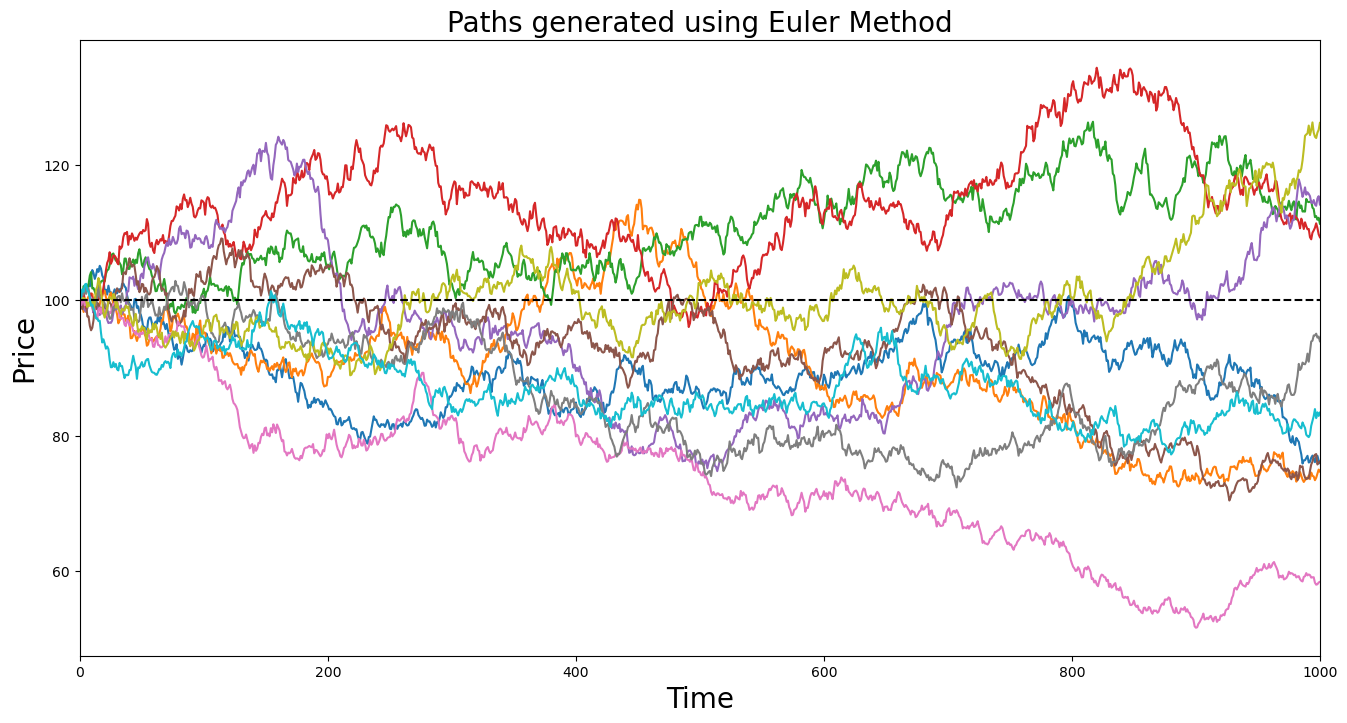

In [ ]:
# plotting stock paths (euler)
europut = MCoptionPricer('european', 'call', 100, 100, 0.25)
europut.getPrice(plot = True, npaths = 10);

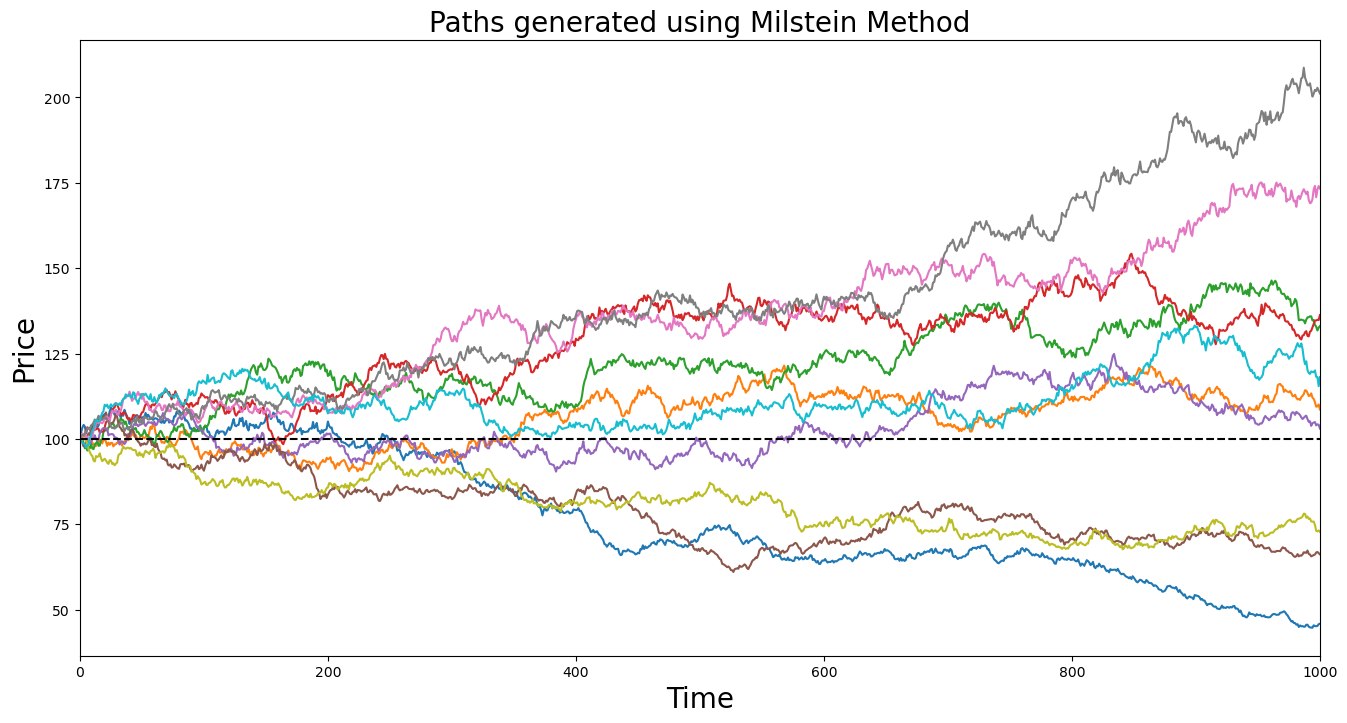

In [ ]:
# plotting stock paths (milstein)
europut = MCoptionPricer('european', 'call', 100, 100, 0.25)
europut.getPrice(method = 'milstein', plot = True, npaths = 10);

In [ ]:
#bs exact price for euro options
S0 = 70
K = 130
r = 0.07
sigma = 0.25
T = 1.0

d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
put_price  = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

print(f"European Call Price: {call_price:.4f}")
print(f"European Put Price:  {put_price:.4f}")

European Call Price: 0.1131
European Put Price:  51.3243


In [ ]:
# terminal basic
S0, K, r, sigma, T = 70, 130, 0.07, 0.25, 1.0
N = 1024

rng = np.random.default_rng(0)
Z = rng.normal(size = N)
ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
disc_payoffs = np.exp(-r*T) * np.maximum(ST - K, 0.0)
price_mc = disc_payoffs.mean()
std_err = disc_payoffs.std(ddof=1) / np.sqrt(N)

(price_mc, std_err)

(0.05913088494007343, 0.029547521295721472)

In [ ]:
# terminal antithetic
S0, K, r, sigma, T = 70, 130, 0.07, 0.25, 1.0
N = 1024

rng = np.random.default_rng(0)
Z = rng.normal(size = N)
antiZ = -Z
ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
antiST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * antiZ)
disc_payoffs = np.exp(-r*T) * np.maximum(ST - K, 0.0)
antidisc_payoffs = np.exp(-r*T) * np.maximum(antiST - K, 0.0)
paired_avg = 0.5 * (disc_payoffs + antidisc_payoffs)
price_mc = np.mean(paired_avg)
std_err = paired_avg.std(ddof=1) / np.sqrt(N)

(price_mc, std_err)

(0.1451447869596705, 0.04704041466089442)

In [ ]:
#importance sampling
S0, K, r, sigma, T = 70, 130, 0.07, 0.25, 1.0
N = 1024

Z_star = (np.log(K/S0) - (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
mu = max(0.0, Z_star + 1.0)

rng = np.random.default_rng(0)
Z_mu = rng.normal(loc=mu, scale=1.0, size=N)

weights = np.exp(-mu*Z_mu + 0.5*mu**2)

ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z_mu)
payoff = np.maximum(ST - K, 0.0)
disc_payoff = np.exp(-r*T) * payoff

Y = weights * disc_payoff
price_is = Y.mean()
std_err_is = Y.std(ddof=1) / np.sqrt(N)

(mu, price_is, std_err_is)

(3.321156833624894, 0.11985059471718733, 0.00414535895938793)

In [ ]:
# cv method
S0, K, r, sigma, T = 70, 130, 0.07, 0.25, 1.0
N = 1024

rng = np.random.default_rng(0)
Z  = rng.standard_normal(N)
ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)

X = np.exp(-r*T) * np.maximum(ST - K, 0.0)
Y = np.exp(-r*T) * ST
EY = S0

cov_XY = np.cov(X, Y, ddof=1)[0,1]
var_Y  = np.var(Y, ddof=1)
beta   = cov_XY / var_Y

X_cv = X - beta*(Y - EY)

price_cv  = X_cv.mean()
se_cv     = X_cv.std(ddof=1) / np.sqrt(N)

(beta, price_cv, se_cv)

(0.013897959384434583, 0.07281122762606491, 0.028617214756624994)

In [ ]:
# quasi sobol
S0, K, r, sigma, T = 70, 130, 0.07, 0.25, 1.0
N = 1024

sobol = qmc.Sobol(d=1, scramble=True)
U = sobol.random(N).flatten()
Z = norm.ppf(U)

ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
disc_payoffs = np.exp(-r*T) * np.maximum(ST - K, 0.0)
price_mc = disc_payoffs.mean()
std_err = disc_payoffs.std(ddof=1) / np.sqrt(N)

(price_mc, std_err)

(0.10507736335474684, 0.04310949001402428)

In [ ]:
# pricing under and in barrier option
daibarrierput = MCoptionPricer('daibarrier', 'put', initialPrice = 100, strike = 110, B = 90)
daibarrierput.getPrice()

11.095390603722262

In [ ]:
# pricing under and in barrier option
daibarriercall = MCoptionPricer('daibarrier', 'call', initialPrice = 100, strike = 110, B = 80)
daibarriercall.getPrice()

0.18989773542313543

In [21]:
# no variance eurocall
eurocall = MCoptionPricer(optionStyle = 'european', optionType = 'call', initialPrice = 150, strike = 50)
eurocall.getPrice(method = 'milstein', npaths = 10000, nt = 1000)

103.30944307395316